In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d as interp1d

/home/users/yandanw/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_262/func_0/'

In [3]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')
### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
### Unifrom the units and Make then intigers ###
stimulus_start_times = (stimulus_start_times*100).astype('int') #index needs to be an integers


####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))
### find the timestamps for neural data ###
fixed = brainsss.load_fda_meanbrain()

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'heading': short = 'h'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
    #fictrac[short] = np.roll(fictrac[short],400) # <------- misalignment is corrected !!!!!!
fictrac_timestamps = np.arange(0,expt_len,resolution)

fictrac['h'] = np.rad2deg(fictrac['h'])

def extract_traces(fictrac, stim_times, pre_window, post_window, behavior='Z'):
    traces = []
    for i in range(len(stim_times)):
        trace = fictrac[behavior][stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace

### Prep for neural data ###
neural_file = os.path.join(func_path, 'functional_channel_2_moco_zscore_highpass.h5') #
with h5py.File(neural_file, 'r') as h:
    print(h['data'].shape)
    neural = h['data'][:]


### Prep for Explotion ###
atlas = brainsss.load_roi_atlas()

explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

loading photodiode data... done
Trying to load timestamp data from hdf5 file.
Success.
(256, 128, 49, 3384)


In [1]:
256*128

32768

In [ ]:
(2000,49,3384)

In [6]:
timestamps.shape
heading.shape
fictrac_timestamps.shape

(180000,)

In [5]:
heading = fictrac['h']-fictrac['h'][100]
### The bar showed at 1st second
### so the starting position of the bar should remove the deviation created by the 1 secnd.

### move negative values to be just under 360, and move nums above 360 to be just above 0
heading = heading%360
# timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))
### find the timestamps for neural data ###
fictrac_timestamps = np.arange(0,1800000,10)

def interpolate_to_neural(slice_num, timestamps):
    x = timestamps[:, slice_num]
    f = interp1d(fictrac_timestamps, heading, fill_value="extrapolate") 
    ynew = f(x)
    return ynew

In [7]:
turning = fictrac['Z']-fictrac['Z'][100]
### The bar showed at 1st second
### so the starting position of the bar should remove the deviation created by the 1 secnd.
def interpolate_turning_to_neural(slice_num, timestamps):
    x = timestamps[:, slice_num]
    f = interp1d(fictrac_timestamps, turning, fill_value="extrapolate") 
    ynew = f(x)
    return ynew

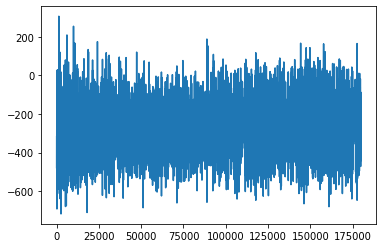

In [8]:
plt.plot(turning)

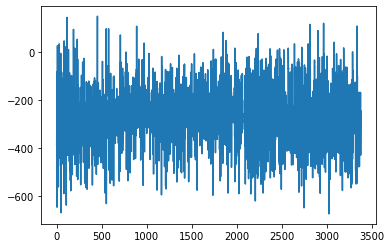

In [9]:
turning_interpolated_single = interpolate_turning_to_neural(10, timestamps)

plt.plot(turning_interpolated_single)

In [10]:
bins = np.arange(-180,181,30)
all_slices = []
for z in range(49):
    print(z)
    slice_neural = neural[:,:,z,:]
    
    heading_interpolated = interpolate_to_neural(z,timestamps)
    ### redefine 0
    heading_interpolated -= 180
    
    avg_neural_barposition = []
    bin_middle = []
    for i in range(len(bins)-1):
        start = bins[i]
        stop = bins[i+1]
        bin_middle.append((start+stop)/2)
        ids = np.where(np.logical_and(heading_interpolated>start, heading_interpolated<=stop))[0]
        avg_neural_barposition.append(np.mean(slice_neural[:,:,ids],axis=2))
    all_slices.append(np.asarray(avg_neural_barposition))
all_slices = np.asarray(all_slices)


#STA_brain should be shape (12,256,128,49)
all_slices = np.moveaxis(all_slices,0,3)
all_slices.shape


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


(12, 256, 128, 49)

In [11]:
bin_middle

[-165.0,
 -135.0,
 -105.0,
 -75.0,
 -45.0,
 -15.0,
 15.0,
 45.0,
 75.0,
 105.0,
 135.0,
 165.0]

In [12]:
bins[2]

-120

In [14]:
one_slice = all_slices[3,:,:,:]
one_slice.shape

(256, 128, 49)

In [110]:
turning_interpolated_single = interpolate_turning_to_neural(20, timestamps)
heading_interpolated_single = interpolate_to_neural(20,timestamps)
ids_s= np.where(np.logical_and(heading_interpolated_single>0,heading_interpolated_single<10))
ins_s= np.where(turning_interpolated_single<0)
#idx_m = np.where(ids_s == ins_s)


In [111]:
ids_s[0]

array([  61,   62,  207,  211,  248,  250,  271,  442,  447,  465,  704,
        707,  711,  724, 1028, 1205, 1286, 1287, 1288, 1289, 1290, 1291,
       1292, 1293, 1294, 1881, 1907, 1908, 1925, 2054, 2056, 2063, 2096,
       2649, 2715, 2838, 2924, 2938, 3009, 3023, 3319, 3321])

In [113]:
print(np.intersect1d(ids_s[0],ins_s[0]))

[  61   62  207  211  248  250  271  442  447  465  704  707  711  724
 1028 1205 1286 1287 1288 1289 1290 1291 1292 1293 1294 1881 1907 1908
 1925 2054 2056 2063 2096 2649 2715 2838 2924 2938 3009 3023 3319 3321]


In [114]:
ins_s[0].shape

(3359,)

In [95]:
a = np.logical_and(heading_interpolated_single>0,heading_interpolated_single<30)
np.where(a)

(array([  21,   23,   60,   61,   62,  207,  211,  227,  237,  238,  239,
         240,  241,  242,  243,  244,  245,  246,  247,  248,  249,  250,
         271,  282,  441,  442,  443,  444,  445,  447,  449,  456,  457,
         459,  462,  463,  465,  466,  467,  468,  469,  470,  471,  526,
         537,  628,  629,  637,  704,  707,  711,  713,  718,  719,  724,
         772,  773,  776,  778,  783,  784,  785,  786,  948,  949,  951,
        1028, 1076, 1170, 1205, 1232, 1233, 1279, 1286, 1287, 1288, 1289,
        1290, 1291, 1292, 1293, 1294, 1295, 1321, 1335, 1404, 1405, 1406,
        1412, 1413, 1414, 1472, 1519, 1521, 1559, 1668, 1669, 1734, 1742,
        1792, 1793, 1825, 1830, 1878, 1881, 1886, 1907, 1908, 1925, 1926,
        1927, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1939,
        1941, 2044, 2045, 2046, 2050, 2054, 2056, 2057, 2058, 2059, 2060,
        2061, 2062, 2063, 2096, 2100, 2161, 2185, 2288, 2289, 2325, 2373,
        2423, 2649, 2650, 2655, 2661, 

In [85]:
np.where(-150<heading_interpolated_single[0]<=-120)

(array([], dtype=int64),)

In [34]:
turning_interpolated_single.shape

(3384,)

(array([2.3000e+02, 2.7210e+03, 1.3585e+04, 3.8403e+04, 8.5144e+04,
        2.8750e+04, 9.1630e+03, 1.7970e+03, 1.8300e+02, 2.4000e+01]),
 array([-717.0389291 , -614.73728157, -512.43563404, -410.13398652,
        -307.83233899, -205.53069146, -103.22904393,   -0.9273964 ,
         101.37425113,  203.67589865,  305.97754618]),
 <BarContainer object of 10 artists>)

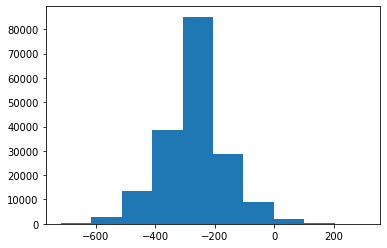

In [13]:
plt.hist(turning)

In [14]:
bins = np.arange(-180,181,30)
all_slices_HT = []
for z in range(49):
    print(z)
    slice_neural = neural[:,:,z,:]
    
    heading_interpolated = interpolate_to_neural(z,timestamps)
    ### redefine 0
    heading_interpolated -= 180
    
    turning_interpolated = interpolate_turning_to_neural(z,timestamps)
    
    avg_neural_barposition_HT = []
    bin_middle = []
    for i in range(len(bins)-1):
        start = bins[i]
        stop = bins[i+1]
        bin_middle.append((start+stop)/2)
        ids = np.where(np.logical_and(heading_interpolated>start, heading_interpolated<=stop))[0]
        ins_l = np.where(turning_interpolated < 0)
        idx = np.intersect1d(ids,ins_l)
        avg_neural_barposition_HT.append(np.mean(slice_neural[:,:,idx],axis=2))
    all_slices_HT.append(np.asarray(avg_neural_barposition_HT))
all_slices_HT = np.asarray(all_slices_HT)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [9]:
all_slices_HT.shape

(49, 12, 256, 128)

In [15]:
#STA_brain should be shape (12,256,128,49)
all_slices_HT = np.moveaxis(all_slices_HT,0,3)
all_slices_HT.shape


(12, 256, 128, 49)

In [36]:
same = np.intersect1d(all_slices,all_slices_HT)
same

array([-0.658294  , -0.60276043, -0.6013227 , ...,  0.703802  ,
        0.7293068 ,  0.75296193], dtype=float32)

In [28]:
all_slices.shape

(12, 256, 128, 49)

In [38]:
12*256*128*49

19267584

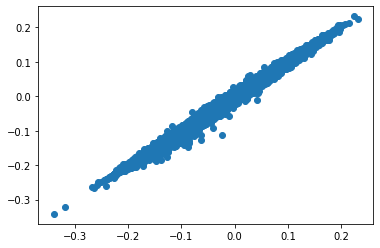

In [37]:
plt.scatter(all_slices[11,:,:,20],all_slices_HT[11,:,:,20])

In [27]:
same.shape

(5961624,)

In [19]:
same_allslice= np.intersect1d(all_slices,all_slices)


In [42]:
same_allslice.shape

(17076545,)

In [47]:
diff = all_slices - all_slices_HT

In [29]:
diff.shape

(12, 256, 128, 49)

In [ ]:
avg_neural_barposition = []
bin_middle = []
for i in range(len(bins)-1):
    start = bins[i]
    stop = bins[i+1]
    bin_middle.append((start+stop)/2)
    ids = np.where(np.logical_and(heading_interpolated>start, heading_interpolated<=stop))[0]
    avg_neural_barposition.append(np.mean(slice_neural[:,:,ids],axis=2))
    

np.append((bins-18),(306+36))
plt.figure(figsize=(10,30))
for i in range(len(avg_neural_barposition)):
    plt.subplot(12,1,i+1)
    plt.imshow(avg_neural_barposition[i].T,vmin=-0.5,vmax=0.5,cmap='seismic')
    plt.ylabel(bin_middle[i])

In [52]:
warps = brainsss.warp_STA_brain(STA_brain=np.rollaxis(diff,3,0), fly='fly_262', fixed=fixed, anat_to_mean_type='myr')

In [53]:
explosions = []
t0 = time.time()
for angle in range(12):
    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = warps[angle][:,:,::-1]
    vmax = 0.5
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic',
                                                        diverging=True)#'hot')
    explosions.append(explosion_map)

In [51]:
data_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_262/'

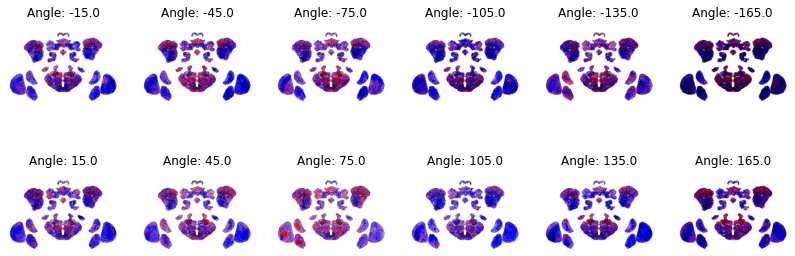

In [54]:
plt.figure(figsize=(14,5))

for k,i in enumerate([5, 4, 3, 2, 1, 0, 6, 7, 8, 9, 10, 11]):
    plt.subplot(2,6,k+1)
    plt.imshow(explosions[i][150:,:])
    plt.title(F"Angle: {bin_middle[i]}")
    plt.axis('off')
    
save_file = os.path.join(data_path, 'figs', '20230131')
plt.savefig(save_file,dpi=300,bbox_inches='tight',transparent=False)

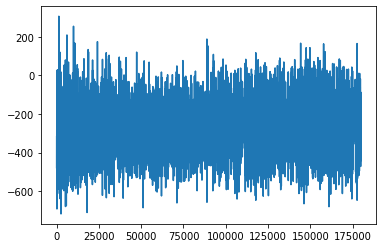

In [7]:
plt.plot(turning)

In [120]:
corrs = []
behavior = 'dRotLabZ'
for z in range(49):
    fictrac_trace = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,z])
    fictrac_trace_L = np.clip(fictrac_trace.flatten(),None,0)*-1 #only needed for Z that has +-.
    # shifted_beh = np.roll(fictrac['Y'][:,0],8) # mismatch of the time
    for voxel in range(2000):
        corrs.append(scipy.stats.pearsonr(all_signals[z,voxel,:], fictrac_trace.flatten())[0])

In [121]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

def supervoxel_to_full_res(brain, cluster_labels):
    n_clusters = brain.shape[1]
    
    reformed_brain = []
    for z in range(49):
        colored_by_betas = np.zeros((256*128))
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_labels[z,:]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = brain[z,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        reformed_brain.append(colored_by_betas)
    return np.asarray(reformed_brain)

whole_corr = np.reshape(np.asarray(corrs),(49,2000))


In [123]:
whole_corr.shape

(49, 2000)

In [131]:
timestamps.shape

(3384, 49)

In [133]:
bins = np.arange(-180,181,30)
all_slices_TH = []
for z in range(49):
    print(z)
    slice_neural = whole_corr[z,:]
    
    heading_interpolated = interpolate_to_neural(z,whole_corr)
    ### redefine 0
    heading_interpolated -= 180
    
    avg_neural_barposition_TH = []
    bin_middle = []
    for i in range(len(bins)-1):
        start = bins[i]
        stop = bins[i+1]
        bin_middle.append((start+stop)/2)
        ids_TH = np.where(np.logical_and(heading_interpolated>start, heading_interpolated<=stop))[0]
        avg_neural_barposition_TH.append(np.mean(whole_corr[:,ids_TH],axis=1))
    all_slices_TH.append(np.asarray(avg_neural_barposition_TH))
all_slices_TH = np.asarray(all_slices_TH)


#STA_brain should be shape (12,256,128,49)
all_slices_TH = np.moveaxis(all_slices,0,3)
all_slices_TH.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


/home/users/yandanw/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/home/users/yandanw/.local/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning:

invalid value encountered in true_divide



(128, 49, 12, 256)

In [134]:
whole_corr_reformed = supervoxel_to_full_res(whole_corr, cluster_labels)
STA_brain = np.swapaxes(all_slices_TH[np.newaxis,:,:,:],0,1)
# STA_brain.shape
warps_ZPOS = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_262', fixed=fixed, anat_to_mean_type='myr')

input_canvas = np.zeros((500,500,3)) #+.5 #.5 for diverging
data_to_plot = warps_ZPOS[0][:,:,::-1]
vmax = .2
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='hot',
                                                            diverging=False)#'hot')

ValueError: must give a spacing value for each dimension (4)

In [10]:
left_turning= np.clip(fictrac['Z'],0,360)

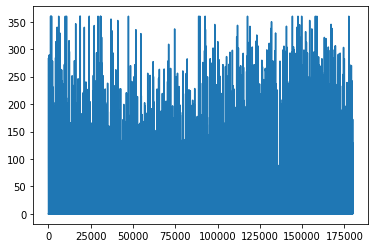

In [11]:
plt.plot(left_turning)

In [12]:
right_turning = np.clip(fictrac['Z'],-360,0)

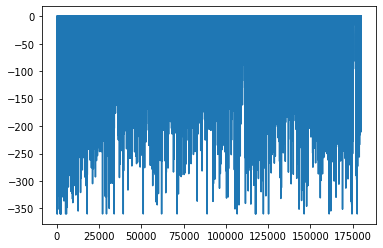

In [13]:
plt.plot(right_turning)

In [14]:
turning.shape

(180000,)

In [15]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))
### 1. find the timestamps for neural data ###

Trying to load timestamp data from hdf5 file.
Success.


In [16]:
timestamps.shape

(3384, 49)

In [17]:
fictrac_timestamps = np.arange(0,1800000,10)

In [18]:
len(fictrac_timestamps)

180000

In [19]:
from scipy.interpolate import interp1d as interp1d
def interpolate_to_neural(slice_num, timestamps):
    x = timestamps[:, slice_num]
    f = interp1d(fictrac_timestamps, heading, fill_value="extrapolate") 
    ynew = f(x)
    return ynew

In [20]:
neural_file = os.path.join(func_path, 'functional_channel_2_moco_zscore_highpass.h5') #
with h5py.File(neural_file, 'r') as h:
    print(h['data'].shape)
    neural = h['data'][:]

(256, 128, 49, 3384)


In [ ]:
whole_corr = np.reshape(np.asarray(corrs),(49,2000))
whole_corr_reformed = supervoxel_to_full_res(whole_corr, cluster_labels)
STA_brain = np.swapaxes(whole_corr_reformed[np.newaxis,:,:,:],0,1)
# STA_brain.shape
warps_ZPOS = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_231', fixed=fixed, anat_to_mean_type='myr')